## DSC 180AB Data Science Capstone
### Replication Project

Team Members: Moses Oh, James Dai, Costin Smilovici, Tyler Tran, Vedan Desai

### Table of Contents
To return to the table of contents, click on the number at any major section heading.

[1. Introduction](#1.-Introduction)

[2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)

[3. Model Development](#3.-Model-Development)

[4. Model Evaluation](#4.-Model-Evaluation)

[5. Bias Mitigation](#5.-Bias-Mitigation)

[6. Results Summary](#6.-Results-Summary)

[7. Explainability](#7.-Explainability)

[8. Conclusion & Discussion](#8.-Conclusion-&-Discussion)


## This tutorial demonstrates classification model learning with bias mitigation as a part of a Care Management use case using Medical Expenditure data.

The notebook demonstrates how the AIF 360 toolkit can be used to detect and reduce bias when learning classifiers using a variety of fairness metrics and algorithms . It also demonstrates how explanations can be generated for predictions made by models learnt with the toolkit using LIME.

* Classifiers are built using Logistic Regression as well as Random Forests.
* Bias detection is demonstrated using several metrics, including disparate impact, average odds difference, statistical parity difference, equal opportunity difference, and Theil index.
* Bias alleviation is explored via a variety of methods, including reweighing (pre-processing algorithm), prejudice remover (in-processing algorithm), and disparate impact remover (pre-processing technique).
* Data from the [Medical Expenditure Panel Survey](https://meps.ahrq.gov/mepsweb/) is used in this tutorial.


The Medical Expenditure Panel Survey (MEPS) provides nationally representative estimates of health expenditure, utilization, payment sources, health status, and health insurance coverage among the noninstitutionalized U.S. population. These government-produced data sets examine how people use the US healthcare system.

MEPS is administered by the Agency for Healthcare Research and Quality (AHRQ) and is divided into three components: 
* Household
* Insurance/Employer, and 
* Medical Provider. 

These components provide comprehensive national estimates of health care use and payment by individuals, families, and any other demographic group of interest.

### [1.](#Table-of-Contents) Introduction

The [AI Fairness 360 toolkit](https://github.com/Trusted-AI/AIF360) is an extensible open-source library containing techniques developed by the research community to help detect and mitigate bias in machine learning models throughout the AI application lifecycle. AI Fairness 360 package is available in both Python and R. Documentation is available [here](https://aif360.readthedocs.io/en/v0.2.3/index.html)

The AI Fairness 360 package includes: 
- a comprehensive set of metrics for datasets and models to test for biases,
- explanations for these metrics, and
- algorithms to mitigate bias in datasets and models
It is designed to translate algorithmic research from the lab into the actual practice of domains as wide-ranging as finance, human capital management, healthcare, and education

#### 1.1 Use Case

**In order to demonstrate how AIF360 can be used to detect and mitigate bias in classfier models, we adopt the following use case:**

* Data scientist develops a 'fair' healthcare utilization scoring model with respect to defined protected classes. Fairness may be dictated by legal or government regulations, such as a requirement that additional care decisions be not predicated on factors such as race of the patient.
* Developer takes the model AND performance characteristics / specs of the model (e.g. accuracy, fairness tests, etc. basically the model factsheet) and deploys the model in an enterprise app that prioritizes cases for care management.
* The app is put into production and starts scoring people and making recommendations. 
* Explanations are generated for each recommendation
* Both recommendations and associated explanations are given to nurses as a part of the care management process. The nurses can evaluate the recommendations for quality and correctness and provide feedback.
* Nurse feedback as well as analysis of usage data with respect to specs of the model w.r.t accuracy and fairness is communicated to AI Ops specialist and LOB user periodically.
* When significant drift in model specs relative to the model factsheet is observed, the model is sent back for retraining.

#### 1.2 Data
Released as an ASCII file (with related SAS, SPSS, and STATA programming statements) and a SAS transport dataset, this public use file provides information collected on a nationally representative sample of the civilian noninstitutionalized population of the United States for calendar year 2015. This file consists of MEPS survey data obtained in Rounds 3, 4, and 5 of Panel 19 and Rounds 1, 2, and 3 of Panel 20 (i.e., the rounds for the MEPS panels covering calendar year 2015) and consolidates all of the final 2015 person-level variables onto one file. This file contains the following variables previously released on HC-174: survey administration, language of interview variable, demographics, parent identifiers, health status, disability days variables, access to care, employment, quality of care, patient satisfaction, health insurance, and use variables. The HC-181 file also includes these variables: income variables and expenditure variables.

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

#### 1.3 Methodology 

For each dataset, the sensitive attribute is 'RACE' constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non Hispanic); 'Non-Whites' that included everyone else.  

* Along with race as the sensitive feature, other features used for modeling include demographics  (such as age, gender, active duty status), physical/mental health assessments, diagnosis codes (such as history of diagnosis of cancer, or diabetes), and limitations (such as cognitive or hearing or vision limitation).
* To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.
* To simulate the scenario, each dataset is split into 3 parts: a train, a validation, and a test/deployment part.

**We assume that the model is initially built and tuned using the 2015 Panel 19 train/test data**
* It is then put into practice and used to score people to identify potential candidates for care management. 
* Initial deployment is simulated to 2015 Panel 20 deployment data. 
* To show change in performance and/or fairness over time, the 2016 Panel 21 deployment data is used. 
* Finally, if drift is observed, the 2015 train/validation data is used to learn a new model and evaluated again on the 2016 deployment data

### 1.4 Insert writeup of overall replication project goals and big picture thinking (2-3 paragraphs).  
* Why do we care about this? 
* What would the benefit of predicting utilization be? 
* What might occur if there are errors?
* Who are the affected parties and stakeholders?
* Other thoughts?

**Write up here:**

Healthcare utilization is a measurement of a patient’s total number of trips to some sort of medical care, a trait commonly associated with higher health care costs. 

The reason we care about predicting healthcare utilization is because by ensuring that various groups of stakeholders can receive the appropriate standard of care, we can potentially help enable a healthcare system that is able to give the right amount of care to the right patients who require it. Ultimately the US healthcare system is commonly considered by both its local populace and the international community to be highly inefficient, so this predictive system is a step in the right direction for perhaps the nation as a whole.

Being able to predict healthcare utilization would be of great benefit to many stakeholders traditionally associated with health insurance. Insurance providers would be able to create or tailor existing plans to better target groups in need based on their projected utilization of services. The resulting, well-working recommendations would be able to block users into utilization groups to maximize their likelihood of acquiring insurance best suited to their healthcare utilization needs. In turn, widespread adoption of more utilization accurate healthcare plans would lead to higher insurance utilization for consumers and support from hospitals, providing health benefits to the populace. Additionally, having a better recognition of what factors cause greater utilization could be of benefit to physicians looking to recommend plans suitable for their patients. 

Errors in utilization prediction would lead to mismatched insurance plans for users based on their utilization. Recommending users an insurance plan with insufficient coverage for things like inpatient services may lead to a significant increase in out-of-pocket financial burden. Similarly, burdening customers with increased insurance costs relative to their needs would be wasteful for the consumer. 

---
End of Introduction

### [2.](#Table-of-Contents) Exploratory Data Analysis (EDA)


The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

See the corresponding [Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

##### Key MEPS dataset features include:
* **Utilization**: To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have **'high'** utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.

#### 2.0 Pre-processing Scripts (for each Panel)

There is currently minimal EDA for this tutorial within IBM AIF360 Medical Expenditure Tutorial. Therefore, we have adapted  utility scripts from IBM AIF360 Tutorial for ease of understanding for how datasets were pre-processed. These will be used primarily for EDA purposes. We will utilize IBM's tutorial for the remainder of the project. We have utilized Pandas for this portion of the project. 

**Note:** these pre-processing script below are run for each data file, and then filtered for each panel. This was done in order to match subsequent portions of the tutorial, and how train/test/validation datasets were split.

#### 2.1 Get and Load Dataset, Apply Pre-processing

**Before Proceeding Ensure You Have:**
* Forked the AIF360 R=repository and cloned locally to your disk or virtual machine
* Downloaded the `h181.csv` and `h192.csv` data files uploaded [here](https://www.kaggle.com/datasets/nanrahman/mepsdata)
* Place the `h181.csv` and `h192.csv` in a folder you can access (we placed it in `../aif360/data/raw/meps/` of our forked AIF360 repository)
* For EDA we only focus on `h181.csv` 

In [29]:
# Imports
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import pandas as pd
import seaborn as sns

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings("ignore")

In [30]:
raw_181 = pd.read_csv('data/h181.csv')

#### Apply pre-processing scripts

In [31]:
default_mappings = {
    'label_maps': [{1.0: '>= 10 Visits', 0.0: '< 10 Visits'}],
    'protected_attribute_maps': [{1.0: 'White', 0.0: 'Non-White'}]}

def default_preprocessing19(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 19
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    df = df.copy()
    def race(row):
        if ((row['HISPANX'] == 2) & (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE#return 'White'
            return 'White'
        return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})
    
    df = df[df['PANEL'] == 19]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

In [32]:
def default_preprocessing20(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 20
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    df = df.copy()
    def race(row):
        if ((row['HISPANX'] == 2) & (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE
            return 'White'
        return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 20]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df


# Investigate the Utilization variable

#### Taken from pre-processing scripts to retain same columns used in model development for tutorial

In [33]:
label_name='UTILIZATION'
favorable_classes=[1.0]
protected_attribute_names=['RACE']
privileged_classes=[['White']]
instance_weights_name='PERWT15F'
categorical_features=['REGION','SEX','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42', 'PHQ242',
                                 'EMPST','POVCAT','INSCOV']

features_to_keep=['REGION','AGE','SEX','RACE','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42',
                                 'PCS42','MCS42','K6SUM42','PHQ242','EMPST','POVCAT','INSCOV','UTILIZATION', 'PERWT15F']
features_to_drop=[]
na_values=[]
# custom_preprocessing=default_preprocessing <- don't need this yet for EDA
metadata=default_mappings


We encourage you to search through the repository and take a look at these scripts, 
they can be found in `../aif360/dataset/` in your forked AIF360 repository:
* AIF360/aif360/datasets/meps_dataset_panel19_fy2015.py
* AIF360/aif360/datasets/meps_dataset_panel20_fy2015.py

To Explore the `Utilization` and `RACE` features, and the variables used to impute these features:
* See the corresponding [HC 181 Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

In [34]:
df_panel_19 = default_preprocessing19(raw_181)
df_panel_19_reduced = df_panel_19[features_to_keep]

In [35]:
df_panel_20 = default_preprocessing20(raw_181)
df_panel_20_reduced = df_panel_20[features_to_keep]

In [36]:
#### END OF PRE-PROCRESSING ####

#### 2.2 Data shape and features

In [37]:
df_panel_19_reduced

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F
0,2,53,1,White,5,-1,2,2,4,3,...,2,25.93,58.47,3,0,4,1,2,1,21854.981705
1,2,56,2,White,3,-1,2,2,4,3,...,2,20.42,26.57,17,6,4,3,2,1,18169.604822
3,2,23,2,White,5,3,2,2,1,1,...,2,53.12,50.33,7,0,1,2,2,0,17191.832515
4,2,3,1,White,6,-1,3,3,1,3,...,-1,-1.00,-1.00,-1,-1,-1,2,2,0,20261.485463
5,3,27,1,Non-White,1,-1,1,4,2,1,...,-1,-1.00,-1.00,-1,-1,1,3,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,3,25,1,Non-White,1,-1,2,2,1,1,...,2,56.71,62.39,0,0,1,1,1,0,4111.315754
16574,3,25,2,Non-White,1,-1,2,2,1,1,...,2,56.71,62.39,0,0,4,1,1,0,5415.228173
16575,3,2,2,White,6,-1,3,3,1,1,...,-1,-1.00,-1.00,-1,-1,-1,1,2,0,3896.116219
16576,1,54,2,Non-White,3,-1,2,2,1,1,...,2,43.97,42.45,24,0,1,3,2,0,4883.851005


In [38]:
df_panel_20_reduced

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F
16578,3,65,1,Non-White,1,-1,4,1,3,3,...,2,39.15,64.23,1,1,1,4,1,0,11966.862856
16579,3,57,2,White,1,-1,2,2,3,3,...,2,23.61,48.28,5,3,4,4,1,1,10300.188631
16580,4,40,1,Non-White,1,-1,2,2,3,3,...,2,53.97,52.82,4,0,1,5,1,0,18749.279706
16581,3,55,2,Non-White,5,-1,2,2,3,3,...,1,40.50,61.61,0,0,1,2,2,0,5532.628347
16582,3,21,2,Non-White,5,1,2,2,3,3,...,-1,-1.00,-1.00,-1,-1,4,2,3,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35422,3,8,1,Non-White,6,-1,3,3,1,1,...,-1,-1.00,-1.00,-1,-1,-1,1,2,0,2812.010290
35423,2,30,2,White,5,-1,2,2,3,2,...,2,44.32,28.41,7,2,1,3,1,1,11481.496934
35424,3,32,1,Non-White,1,-1,2,2,3,2,...,2,36.80,61.23,1,0,1,5,1,0,8357.376060
35425,3,32,2,Non-White,1,-1,2,2,2,2,...,2,56.48,47.77,1,0,1,5,1,0,8389.102961


In [39]:
# Identify feature names
# Check for categorical features

feature_names = np.union1d(df_panel_20_reduced.columns, df_panel_19_reduced.columns)
feature_names = feature_names[feature_names != "UTILIZATION"]

# existing 'categorical' features taken from the pre-procesing scripts above
categorical = np.intersect1d(feature_names, categorical_features)
non_categorical = np.setdiff1d(feature_names, categorical_features)

categorical = np.append(categorical, protected_attribute_names)
non_categorical = non_categorical[non_categorical != "RACE"]


# for feature descriptions and names, see dictionary
categorical, non_categorical

(array(['ACTDTY', 'ACTLIM', 'ADHDADDX', 'ADSMOK42', 'ANGIDX', 'ARTHDX',
        'ARTHTYPE', 'ASTHDX', 'CANCERDX', 'CHBRON', 'CHDDX', 'CHOLDX',
        'COGLIM', 'DFHEAR42', 'DFSEE42', 'DIABDX', 'EMPHDX', 'EMPST',
        'FTSTU', 'HIBPDX', 'HONRDC', 'INSCOV', 'JTPAIN', 'MARRY', 'MIDX',
        'MNHLTH', 'OHRTDX', 'PHQ242', 'POVCAT', 'PREGNT', 'REGION',
        'RTHLTH', 'SEX', 'SOCLIM', 'STRKDX', 'WLKLIM', 'RACE'],
       dtype=object),
 array(['AGE', 'K6SUM42', 'MCS42', 'PCS42', 'PERWT15F'], dtype=object))

In [40]:
df_panel_19_reduced["RACE"].value_counts(dropna =False)  # not sure how they got a "None" into the dataset? Should this be "White"?

Non-White    10174
White         5656
Name: RACE, dtype: int64

In [41]:
df_panel_20_reduced["RACE"].value_counts(dropna =False)

Non-White    10821
White         6749
Name: RACE, dtype: int64

In [42]:
# Summary statistics
# Shapes
df_panel_19_reduced[non_categorical].describe()

,AGE,K6SUM42,MCS42,PCS42,PERWT15F
count,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000
mean,35.090461,1.274289,30.851517,29.358455,8930.337369
std,22.475549,3.955331,26.968146,25.996522,8521.260446
min,0.000000,-9.000000,-9.000000,-9.000000,0.000000
25%,15.000000,-1.000000,-1.000000,-1.000000,3428.548713
50%,33.000000,0.000000,42.480000,39.505000,6146.458935
75%,53.000000,2.000000,56.580000,54.800000,11749.810086
max,85.000000,24.000000,75.510000,72.070000,94264.071559


In [43]:
df_panel_20_reduced[non_categorical].describe()

,AGE,K6SUM42,MCS42,PCS42,PERWT15F
count,17570.000000,17570.000000,17570.000000,17570.000000,17570.000000
mean,35.396187,1.318042,31.174532,29.609575,9322.578166
std,22.662113,3.952222,26.900476,25.940198,8127.601760
min,0.000000,-9.000000,-9.000000,-9.000000,0.000000
25%,15.000000,-1.000000,-1.000000,-1.000000,3833.173318
50%,34.000000,0.000000,42.965000,39.730000,7068.043378
75%,53.000000,2.000000,56.710000,54.800000,12283.549610
max,85.000000,24.000000,73.160000,71.060000,98103.984953


In [44]:
df_panel_19_reduced.shape, df_panel_20_reduced.shape

((15830, 43), (17570, 43))

#### 2.3 Outlier Detection and Handling

For null handling we will do the following:
- We will clean the RACE column to be what it needs to be.
    - This was done by fixing the preprocessing script.
- We will leave -1 and -9 values in categorical columns as is as they can be treated as other categories.
- We will use sampling imputation for imputing -1 and -9 values in quantitative columns as shown below.

In [45]:
#Before handling
df_panel_19_reduced[non_categorical]

,AGE,K6SUM42,MCS42,PCS42,PERWT15F
0,53,3,58.47,25.93,21854.981705
1,56,17,26.57,20.42,18169.604822
3,23,7,50.33,53.12,17191.832515
4,3,-1,-1.00,-1.00,20261.485463
5,27,-1,-1.00,-1.00,0.000000
...,...,...,...,...,...
16573,25,0,62.39,56.71,4111.315754
16574,25,0,62.39,56.71,5415.228173
16575,2,-1,-1.00,-1.00,3896.116219
16576,54,24,42.45,43.97,4883.851005


In [46]:
# Null handling
non_categorical_data = df_panel_19_reduced[non_categorical]
    
for col in non_categorical_data.columns:
    my_filter = non_categorical_data[col] < 0
    sample_from = non_categorical_data.loc[~my_filter,col]
    my_sample = sample_from.sample(len(non_categorical_data.loc[my_filter,col]),replace=True)
    non_categorical_data.loc[my_filter,col] = my_sample.values

df_panel_19_reduced[non_categorical] = non_categorical_data

In [47]:
df_panel_19_reduced[non_categorical]

,AGE,K6SUM42,MCS42,PCS42,PERWT15F
0,53,3,58.47,25.93,21854.981705
1,56,17,26.57,20.42,18169.604822
3,23,7,50.33,53.12,17191.832515
4,3,3,52.93,30.05,20261.485463
5,27,0,51.53,53.59,0.000000
...,...,...,...,...,...
16573,25,0,62.39,56.71,4111.315754
16574,25,0,62.39,56.71,5415.228173
16575,2,5,61.68,54.36,3896.116219
16576,54,24,42.45,43.97,4883.851005


#### 2.4 Correlation Analysis

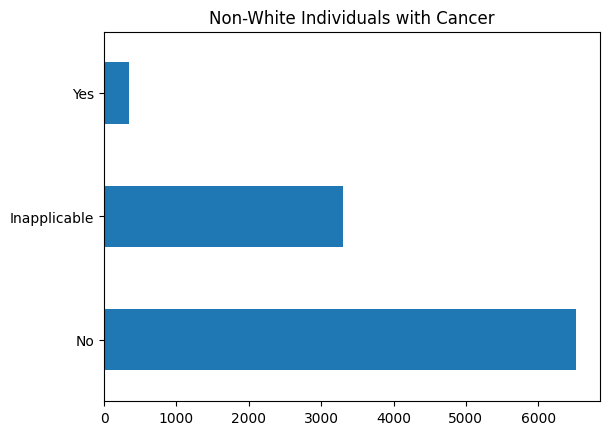

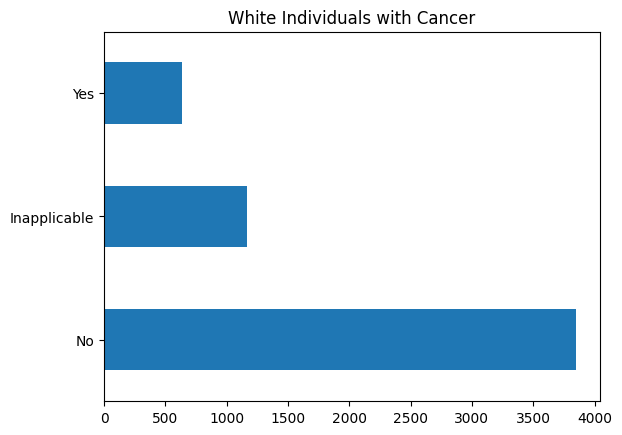

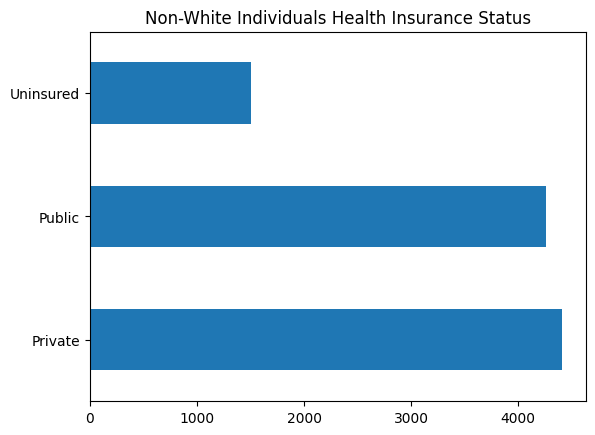

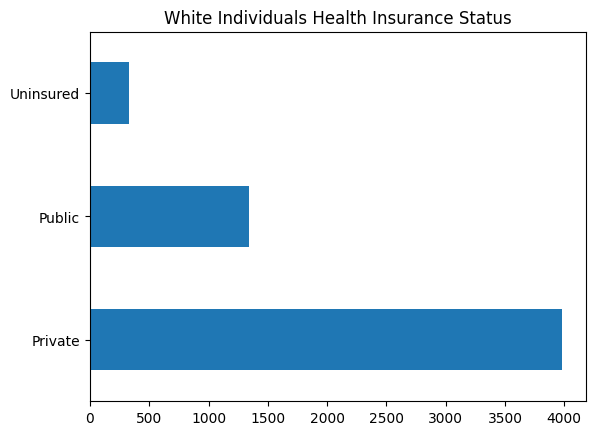

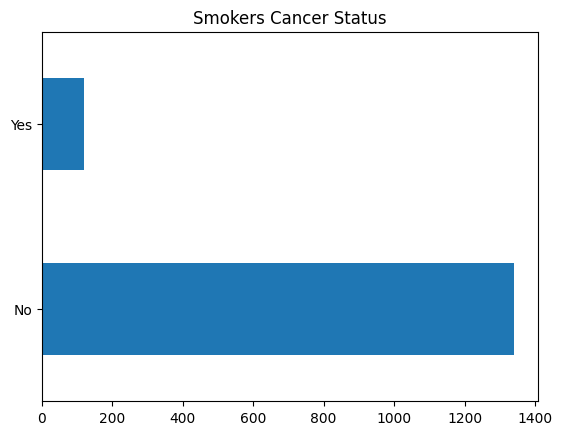

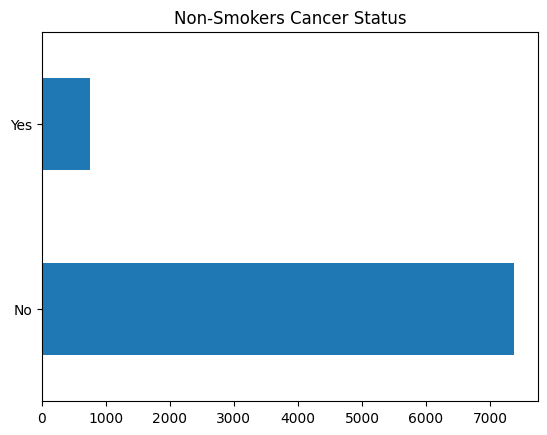

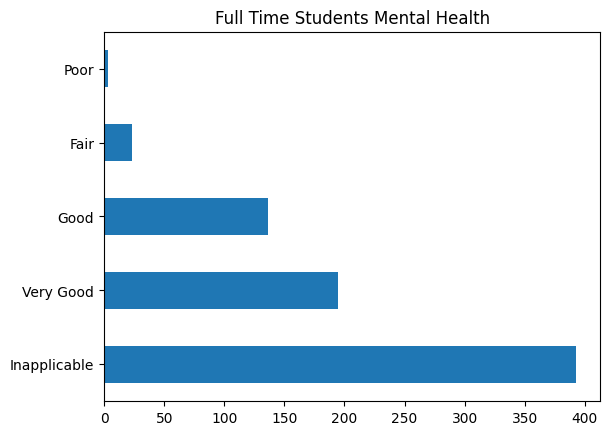

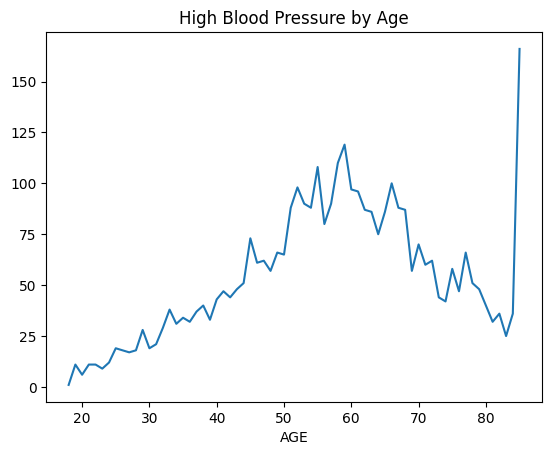

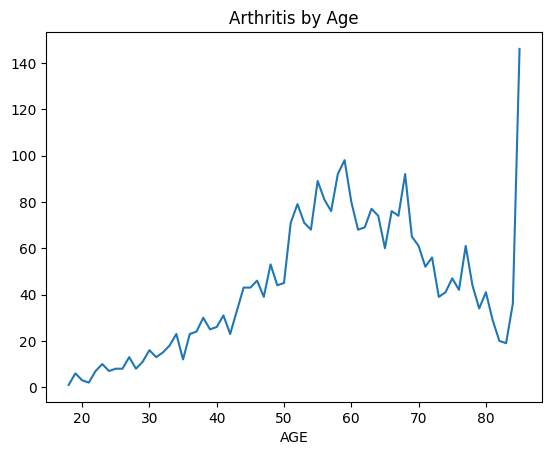

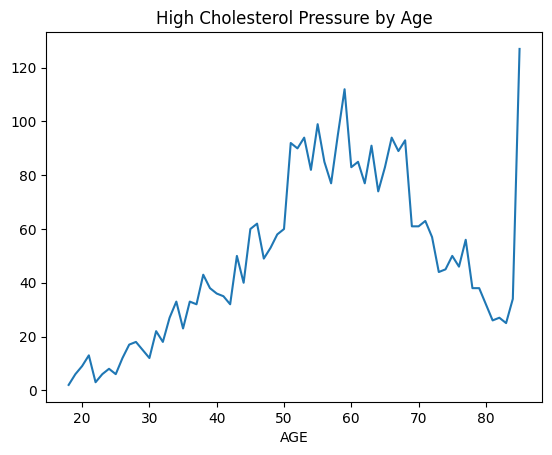

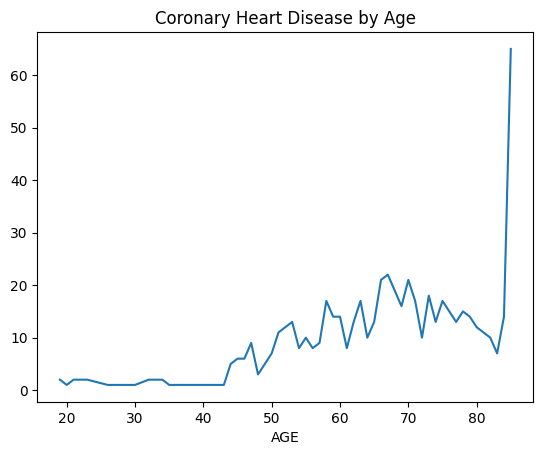

In [48]:
# Preliminary data visualizations
# Preliminary data visualizations
race = df_panel_19_reduced['RACE']
students = df_panel_19_reduced[df_panel_19_reduced['FTSTU'] == 1]
smokers = df_panel_19_reduced[df_panel_19_reduced['ADSMOK42'] == 1]
nonsmokers = df_panel_19_reduced[df_panel_19_reduced['ADSMOK42'] == 2]

high_bp = df_panel_19_reduced[df_panel_19_reduced['HIBPDX'] == 1]
arth = df_panel_19_reduced[df_panel_19_reduced['ARTHDX'] == 1]
high_ch = df_panel_19_reduced[df_panel_19_reduced['CHOLDX'] == 1]
coronary = df_panel_19_reduced[df_panel_19_reduced['CHDDX'] == 1]


#Non-Whites with Cancer
df_panel_19_reduced[race == 'Non-White']['CANCERDX'].value_counts().rename({-1: 'Inapplicable', 1: 'Yes', 2: 'No'}) .plot(kind='barh', title='Non-White Individuals with Cancer')
plt.show()

#White with Cancer
df_panel_19_reduced[race != 'Non-White']['CANCERDX'].value_counts().rename({-1: 'Inapplicable', 1: 'Yes', 2: 'No'}).plot(kind='barh', title='White Individuals with Cancer')
plt.show()

#Non-Whites with Health Insurance
df_panel_19_reduced[race == 'Non-White']['INSCOV'].value_counts().rename({1: 'Private', 2: 'Public', 3: 'Uninsured'}) .plot(kind='barh', title='Non-White Individuals Health Insurance Status')
plt.show()

#White with Health Insurance
df_panel_19_reduced[race != 'Non-White']['INSCOV'].value_counts().rename({1: 'Private', 2: 'Public', 3: 'Uninsured'}).plot(kind='barh', title='White Individuals Health Insurance Status')
plt.show()

#Smokers with Cancer
smokers['CANCERDX'].value_counts().rename({-1: 'Inapplicable', 1: 'Yes', 2: 'No'}).plot(kind='barh', title='Smokers Cancer Status')
plt.show()

#Non-Smokers with Cancer
nonsmokers['CANCERDX'].value_counts().rename({-1: 'Inapplicable', 1: 'Yes', 2: 'No'}).plot(kind='barh', title='Non-Smokers Cancer Status')
plt.show()

#Student Mental Health
students['MNHLTH'].value_counts().rename({1: 'Inapplicable', -1: 'Execellent', 2: 'Very Good', 3: 'Good',4: 'Fair',5:'Poor'}).plot(kind='barh', title='Full Time Students Mental Health')
plt.show()

#High Blood Pressure by Age
high_bp.groupby(by="AGE").size().plot(kind='line', title='High Blood Pressure by Age')
plt.show()

#Arthritis by Age
arth.groupby(by="AGE").size().plot(kind='line', title='Arthritis by Age')
plt.show()

#High Cholesterol Pressure by Age
high_ch.groupby(by="AGE").size().plot(kind='line', title='High Cholesterol Pressure by Age')
plt.show()

#Coronary Heart Disease by Age
coronary.groupby(by="AGE").size().plot(kind='line', title='Coronary Heart Disease by Age')
plt.show()


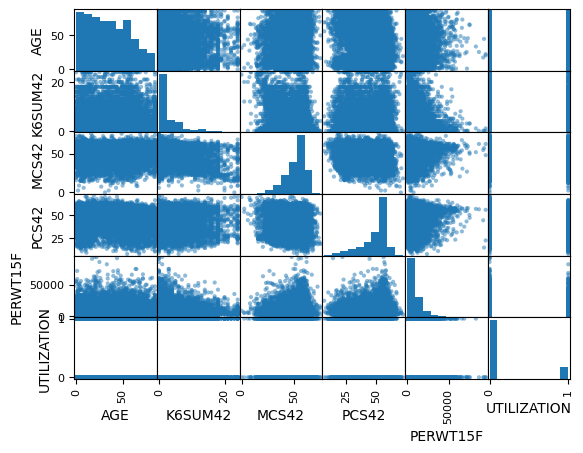

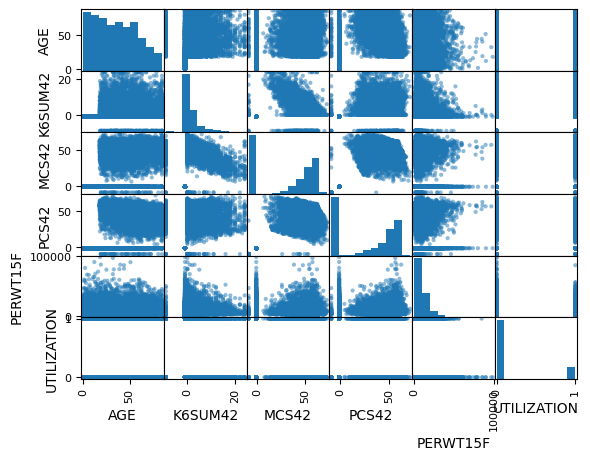

In [49]:
# Correlation plot 1
corr_plot_19 = pd.plotting.scatter_matrix(df_panel_19_reduced[np.append(non_categorical, 'UTILIZATION') ])

# Correlation plot 2
corr_plot_20 = pd.plotting.scatter_matrix(df_panel_20_reduced[np.append(non_categorical, 'UTILIZATION') ])

#### 2.5 Other analysis

In [50]:
# Since the main feature we're predicting is utilization and the correlation plots above are kind of hard to read, let's 
# figure out what features are most correlated with utilization:
corr_19 = df_panel_19_reduced[np.append(non_categorical, 'UTILIZATION')].corr().abs()
corr_19['UTILIZATION'].sort_values(ascending=False)[1:11]

AGE         0.337893
PCS42       0.280709
K6SUM42     0.134079
PERWT15F    0.120534
MCS42       0.110494
Name: UTILIZATION, dtype: float64

In [51]:
# Next let's figure out how much of our population has a 1 v 0 in UTILIZATION:
prop_1 = df_panel_19_reduced['UTILIZATION'].mean()
prop_0 = 1 - prop_1
print('1: ', prop_1)
print('0: ', prop_0)

1:  0.1716993051168667
0:  0.8283006948831333


In [52]:
# But this isn't exactly the best way to go about determining the correlation between a continuous and dichotomous variable
# Instead I'll be using the point biserial correlation in the following cell to figure out what the correlations are:
import scipy.stats as stats

for i in non_categorical:
    print(f"The point-biserial correlation between UTILIZATION and {i} is: ", 
          stats.pointbiserialr(df_panel_19_reduced[i], df_panel_19_reduced['UTILIZATION'])[0])

The point-biserial correlation between UTILIZATION and AGE is:  0.3378928770934882
The point-biserial correlation between UTILIZATION and K6SUM42 is:  0.13407861116842915
The point-biserial correlation between UTILIZATION and MCS42 is:  -0.11049372935816722
The point-biserial correlation between UTILIZATION and PCS42 is:  -0.28070932681257416
The point-biserial correlation between UTILIZATION and PERWT15F is:  0.12053406356328283


-----
End of Exploratory Data Analysis


### End of Replication Part 01 -  EDA


-----
# Start of Replication Part 02 -  Model Development, and Fairness Evaluation

## There are **two** components to `Replication Project Part #02`
1. Training models without de-biasing, using IBM's tutorial
2. Training models without de-biasing, using your own model development techniques including (1) Feature Selection, (2) Encoding, (3) Binning Features, and other items 

#### We will now return to IBM AIF360's [Medical Expenditure Tutorial](https://nbviewer.org/github/IBM/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb) 
_*Note that it is primarily Scikit-learn based_

* A reminder, you will need to fork [AIF360's repository](https://github.com/Trusted-AI/AIF360) into your own GitHub and access the notebook locally or via your method of choice
* AIF360's Repository can be found under: `AIF360`/`Examples`/tutorial_medical_expenditure.ipynb
* Ensure you have your `aif360` environment turned and activated using a miniconda prompt
* Use Jupyter Labs
* Refer to [Week 03](https://nanrahman.github.io/capstone-responsible-ai/weeks/03-Replication-Part-00/) content on the course Website to access the `Quickstart Guide`






### [3.](#Table-of-Contents) Model Development without Debiasing 


First, load all necessary packages

In [53]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.sklearn import metrics

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification

# LIME
from aif360.datasets.lime_encoder import LimeEncoder
import lime
from lime.lime_tabular import LimeTabularExplainer

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score

np.random.seed(1)

### 3.1. Load data & create splits for learning/validating/testing model

In [54]:
(dataset_orig_panel19_train,
 dataset_orig_panel19_val,
 dataset_orig_panel19_test) = MEPSDataset19().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]

In [55]:
metric_orig_panel19_train = BinaryLabelDatasetMetric(
        dataset_orig_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_panel19_train)

print(explainer_orig_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.482305229962759


### 3.2. Learning a Logistic Regression (LR) classifier on original data

#### Training LR model on original data

In [56]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### Validating LR model on original data

In [57]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs


def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

In [58]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_orig_panel19,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

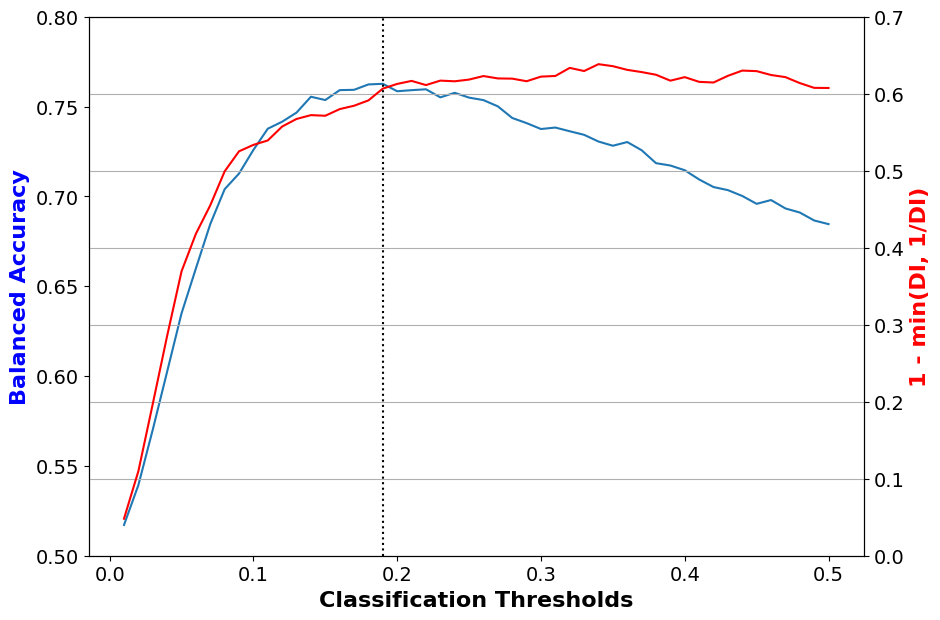

In [59]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

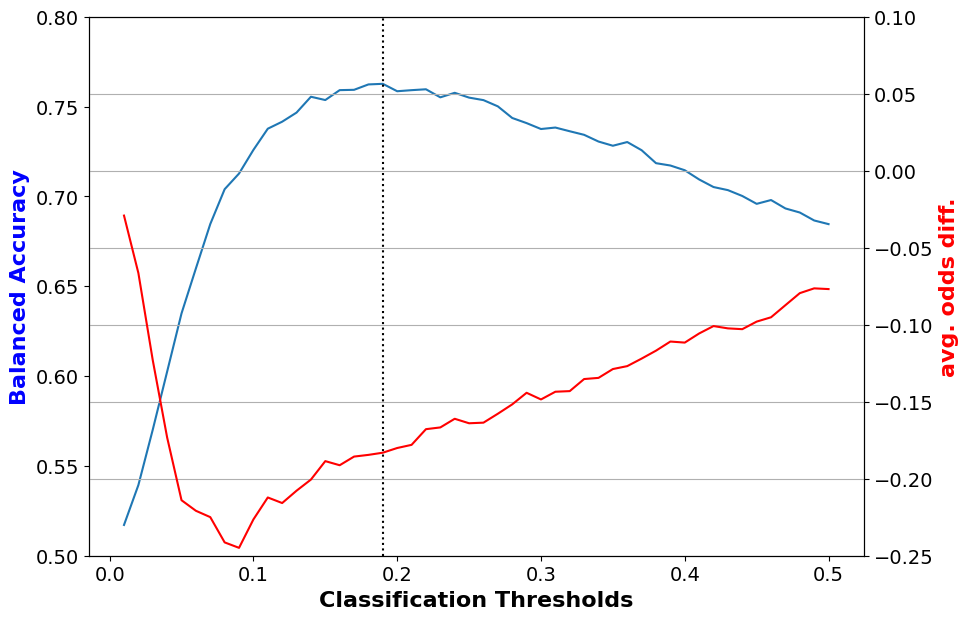

In [60]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [61]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [62]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7627
Corresponding 1-min(DI, 1/DI) value: 0.6066
Corresponding average odds difference value: -0.1831
Corresponding statistical parity difference value: -0.2643
Corresponding equal opportunity difference value: -0.1608
Corresponding Theil index value: 0.0936


#### Testing LR model on original data

In [63]:
lr_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=lr_orig_panel19,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

In [64]:
describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7759
Corresponding 1-min(DI, 1/DI) value: 0.5738
Corresponding average odds difference value: -0.2057
Corresponding statistical parity difference value: -0.2612
Corresponding equal opportunity difference value: -0.2228
Corresponding Theil index value: 0.0921


### 3.3. Learning a Random Forest (RF) classifier on original data

#### Training RF model on original data

In [65]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### Validating RF model on original data

In [66]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=rf_orig_panel19,
                   thresh_arr=thresh_arr)
rf_orig_best_ind = np.argmax(val_metrics['bal_acc'])

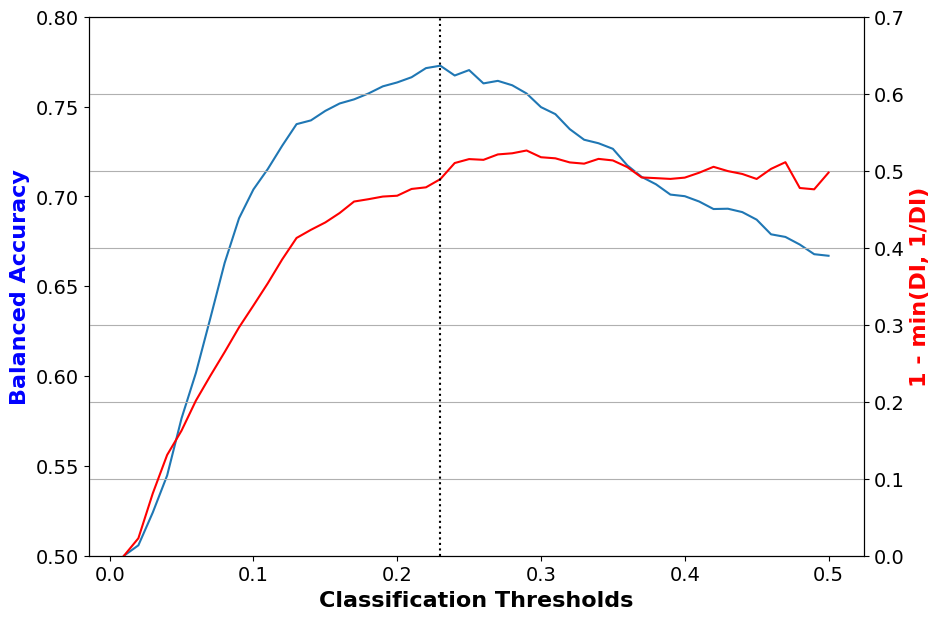

In [67]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

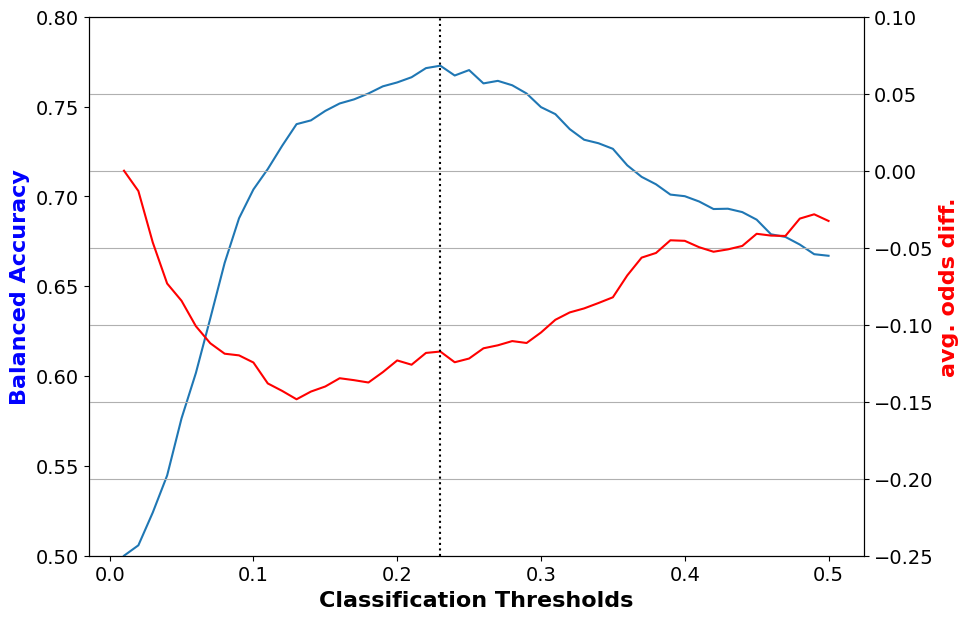

In [68]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [69]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7727
Corresponding 1-min(DI, 1/DI) value: 0.4891
Corresponding average odds difference value: -0.1174
Corresponding statistical parity difference value: -0.1952
Corresponding equal opportunity difference value: -0.1076
Corresponding Theil index value: 0.0893


#### Testing RF model on original data

In [70]:
rf_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=rf_orig_panel19,
                       thresh_arr=[thresh_arr[rf_orig_best_ind]])

In [71]:
describe_metrics(rf_orig_metrics, [thresh_arr[rf_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7640
Corresponding 1-min(DI, 1/DI) value: 0.5040
Corresponding average odds difference value: -0.1346
Corresponding statistical parity difference value: -0.2121
Corresponding equal opportunity difference value: -0.1141
Corresponding Theil index value: 0.0944


### Section 3 Write Up here

### Part-01: For **both** the logistic regression and random forest classifiers learned on the original data, please include explain the results of your fairness metrics. For _each_ metric result briefly describe what this value means in 1-2 sentences (is it fair, is it not fair? Why?)

_Logistic Regression Fairness Metrics_
   * Threshold corresponding to best balanced accuracy: 0.1900
   
   * Best balanced accuracy: 0.7759
       * Balanced accuracy is defined as the mean of Sensitivity and Specificity.
   * Corresponding 1-min(DI, 1/DI) value: 0.5738
       * Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group. This metric is fair if < 0.2, therefore it is not fair in this case.
   * Corresponding average odds difference value: -0.2057
       * The average odds difference value is the average of difference in FPR and TPR for unprivileged and privileged groups. This metric is fair if between -0.1-0.1, therefore it is not fair in this case. (Ideal value of this metric would be 0)
   * Corresponding statistical parity difference value: -0.2612
       * The statistical parity difference value is the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group. This metric is fair if between -0.1-0.1, therefore it is not fair in this case. (Ideal value of this metric would be 0)
   * Corresponding equal opportunity difference value: -0.2228
       *  The difference of true positive rates between the unprivileged and the privileged groups. This metric is fair if between -0.1-0.1, therefore it is not fair in this case. (Ideal value of this metric would be 0)
   * Corresponding Theil index value: 0.0921
       * Generalized entropy of benefit for all individuals in the dataset, with alpha = 1. It measures the inequality in benefit allocation for individuals. This metric is more fair the closer it is to 0. In this case 0.921 is likely to be considered not fair.
   
_Random Forest Fairness Metrics_
   * Threshold corresponding to best balanced accuracy: 0.2300
   * Best balanced accuracy: 0.7638
       * Balanced accuracy is defined as the mean of Sensitivity and Specificity.
   * Corresponding 1-min(DI, 1/DI) value: 0.5141
       * Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group. This metric is fair if < 0.2, therefore it is not fair in this case.
   * Corresponding average odds difference value: -0.1388
       * The average odds difference value is the average of difference in FPR and TPR for unprivileged and privileged groups. This metric is fair if between -0.1-0.1, therefore even though it is close, it is not fair in this case. (Ideal value of this metric would be 0)
   * Corresponding statistical parity difference value: -0.2190
       * The statistical parity difference value is the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group. This metric is fair if between -0.1-0.1, therefore it is not fair in this case. (Ideal value of this metric would be 0)
   * Corresponding equal opportunity difference value: -0.1135
       *  The difference of true positive rates between the unprivileged and the privileged groups. This metric is fair if between -0.1-0.1, therefore it is not fair in this case. (Ideal value of this metric would be 0)
   * Corresponding Theil index value: 0.0936
       * Generalized entropy of benefit for all individuals in the dataset, with alpha = 1. It measures the inequality in benefit allocation for individuals. This metric is more fair the closer it is to 0. In this case 0.921 is likely to be considered not fair.

### Part-02: Please write one paragraph for each question.
1. How can we determine which metrics to use, given our data and use case? You can refer to [Course material](https://nanrahman.github.io/capstone-responsible-ai/weeks/06-Fairness-Assessments/), online research and Guidance provided by [AIF360](http://aif360.mybluemix.net/resources#)
    * Given our data and use case, we can determine which metrics to use in a few ways. One possible solution is to use the flowchart presented during class to determine which types of statistical fairness to strive for. In this flowchart, some of the key guiding elements were whether we have access to ground-truth data, whether our prediction has features correlating to protected classes, and how our model is planned on being used. By following this flow chart, we could pick fairness metric(s) that seem to be suit our use case given the setup of our model. Similarly, AIF360 has guidelines on how to pick appropriate fairness metrics. According to AIF360, metrics should be chosen depending on if the model is concerned with group or individual fairness and the "worldviews" within these fairness metrics.
2. When you have competing fairness metrics, how to pick which to prioritize?
    * When there are competeing fairness metrics, there are often times where one metric is more suited to the application. In this case, the metric that is more relevant should be prioritized versus the metric(s) that are not as well-suited to our use case. This is related to question 1 in how we choose which metrics to use as resources such as the flowchart can help lead to the best metric to use. While AIF360 may suggest more than one metric to pick from, the developer is able to choose which to priortize based on their targeted outcome and view. For example the two viewpoints AIF360 propose are: we’re all equal (WAE) and what you see is what you get (WYSIWYG). Based on the chosen "world-view", there is a corresponding metric to prioritize.
3. What do you do when you encounter different definitions for similar metrics?
    * When encountering different definitions for similar metrics, it is best to conduct proper background research and analysis on the correct definition for the use case of the metric. Similar to question 2, out of the numerous possible metrics there are to choose from, there are ones to prioritize over others. As a result if there are metrics that are similar, but have different definitions, it is best to research which is most appropriate for the use case. 
4. Based on this, which model and fairness metric appears the best to proceed with?
    * Based on our current use case, I believe the best fairness metric(s) would be disparate_impact and statistical parity difference. The reason behind this is because our model is developed focusing on group fairness rather than indiviudal fairness. Furthermore, the "world-view" of the model is "we're all equal" in which all groups have similar abilities with respect to the task (even if we cannot observe this properly). In the domain of this model, all groups within the medical expenditure should have similar utilization regardless. As a result through following the guidance of AIF360, disparate_impact and statistical parity difference are good metrics to measure this.

### [4.](#Table-of-Contents) Additional Model Development



### 4.1A Load data & create splits for learning/validating/testing model

In [72]:
df_panel_19_reduced['RACE'] = (df_panel_19_reduced['RACE'] != 'Non-White').astype(int)
df_panel_20_reduced['RACE'] = (df_panel_20_reduced['RACE'] != 'Non-White').astype(int)

In [73]:
# Use the same methods from Section 3
one_hot = pd.get_dummies(df_panel_19_reduced, columns=categorical_features, drop_first=True)
one_hot = one_hot.sample(frac=1,random_state=57)
train, val, test = BinaryLabelDataset(df=one_hot,
                                      label_names=["UTILIZATION"],
                                      protected_attribute_names=["RACE"], 
                                      privileged_protected_attributes = [0]).split([0.5, 0.8])

sens_ind = 0
sens_attr = train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     train.privileged_protected_attributes[sens_ind]]

GROUPS = (unprivileged_groups,privileged_groups)

### 4.1B Utilize findings from your EDA to complete any additional model development

In [74]:
# Using l1 loss to perform feature selection
EDA_model = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver='saga', max_iter=5000))
gs = GridSearchCV(EDA_model, 
                  {'logisticregression__C': list(np.logspace(-5, 5, 10))}, 
                  n_jobs = -1, 
                  cv = 10,
                  scoring='balanced_accuracy'
                 )
gs.fit(train.features, train.labels.ravel())

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=5000,
                                                           penalty='l1',
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1e-05, 0.0001291549665014884,
                                                   0.0016681005372000592,
                                                   0.021544346900318846,
                                                   0.2782559402207126,
                                                   3.593813663804626,
                                                   46.41588833612782,
                                                   599.4842503189421,
                                                   7742.636826811277,
                                                   100000.0]},
             scoring='balanced_accuracy')

In [75]:
balanced_accuracy_score(gs.predict(val.features), val.labels.ravel())

0.7638450057139603

In [76]:
gs.best_params_

{'logisticregression__C': 3.593813663804626}

In [77]:
# Utilizing Lasso's ablility to set weights to 0, we use the resulting features for our real models
keep = (gs.best_estimator_[1].coef_ != 0)[0]
to_keep = np.array(train.feature_names)[keep]
to_keep

array(['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'PERWT15F', 'REGION_2',
       'REGION_3', 'REGION_4', 'SEX_2', 'MARRY_2', 'MARRY_3', 'MARRY_4',
       'MARRY_5', 'MARRY_6', 'MARRY_7', 'MARRY_8', 'MARRY_9', 'MARRY_10',
       'FTSTU_1', 'FTSTU_2', 'FTSTU_3', 'ACTDTY_2', 'ACTDTY_3',
       'HONRDC_2', 'HONRDC_3', 'HONRDC_4', 'RTHLTH_1', 'RTHLTH_2',
       'RTHLTH_3', 'RTHLTH_4', 'RTHLTH_5', 'MNHLTH_1', 'MNHLTH_2',
       'MNHLTH_3', 'MNHLTH_4', 'MNHLTH_5', 'HIBPDX_1', 'CHDDX_1',
       'CHDDX_2', 'ANGIDX_1', 'MIDX_1', 'OHRTDX_1', 'OHRTDX_2',
       'STRKDX_1', 'EMPHDX_1', 'CHBRON_1', 'CHBRON_2', 'CHOLDX_1',
       'CHOLDX_2', 'CANCERDX_1', 'CANCERDX_2', 'DIABDX_1', 'DIABDX_2',
       'JTPAIN_2', 'ARTHDX_1', 'ARTHDX_2', 'ARTHTYPE_1', 'ARTHTYPE_2',
       'ARTHTYPE_3', 'ASTHDX_2', 'ADHDADDX_1', 'ADHDADDX_2', 'PREGNT_1',
       'PREGNT_2', 'WLKLIM_2', 'ACTLIM_1', 'ACTLIM_2', 'SOCLIM_2',
       'COGLIM_2', 'DFHEAR42_1', 'DFHEAR42_2', 'DFSEE42_1', 'DFSEE42_2',
       'ADSMOK42_1', 'ADSMOK

In [78]:
# Preparing panel 19 for use with the AIF360 library
one_hot_prime = one_hot[to_keep]
one_hot_prime["UTILIZATION"] = one_hot["UTILIZATION"]
train, val, test = BinaryLabelDataset(df=one_hot_prime,
                                      label_names=["UTILIZATION"],
                                      protected_attribute_names=["RACE"], 
                                      privileged_protected_attributes = [0]).split([0.5, 0.8])

In [79]:
# Preparing panel 20 for model drift
one_hot_20 = pd.get_dummies(df_panel_20_reduced, columns=categorical_features, drop_first=True)
one_hot_20 = one_hot_20.sample(frac=1,random_state=57)
one_hot_prime_20= one_hot_20[to_keep]
one_hot_prime_20["UTILIZATION"] = one_hot_20["UTILIZATION"]
model_drift_test = BinaryLabelDataset(df=one_hot_prime_20,
                                      label_names=["UTILIZATION"],
                                      protected_attribute_names=["RACE"], 
                                      privileged_protected_attributes = [0])

### 4.2. Learning a Logistic Regression (LR) classifier on original data

In [80]:
def best_threshold(fitted_model,df,groups,best_thresh=None,model_type="sklearn",scaler=None):
    if model_type == "sklearn":
        y_val_pred_prob = fitted_model.predict_proba(df.features)
        pos_ind = np.where(fitted_model.classes_ == df.favorable_label)[0][0]
    elif model_type == "aif360":
        new_df = df.copy()
        new_df.features = scaler.transform(new_df.features)
        y_val_pred_prob = pr_model.predict(new_df).scores
        pos_ind = 0
    if best_thresh == None:
        best_bar = -1
        best_thresh = -1
        for thresh in np.linspace(0.01, 0.5, 50):
            y_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)
            y_true = df.labels.ravel()
            df_pred = df.copy()
            df_pred.labels = y_pred.reshape(-1,1)
            metric = ClassificationMetric(df, 
                                          df_pred, 
                                          unprivileged_groups=groups[0], 
                                          privileged_groups=groups[1])
            curr_bar = (metric.true_positive_rate() + metric.true_negative_rate()) / 2
            if curr_bar > best_bar:
                best_bar = curr_bar
                best_thresh = thresh
    y_val_pred = (y_val_pred_prob[:, pos_ind] > best_thresh).astype(np.float64)
    y_true = df.labels.ravel()
    df_pred = df.copy()
    df_pred.scores = y_val_pred_prob[:, pos_ind].reshape(-1,1)
    df_pred.labels = y_val_pred.reshape(-1,1)
    return (df_pred, best_thresh)

In [81]:
# val_pred_lr.score.reshape(-1,1)

In [82]:
def print_stats(df,df_pred,groups):
    metric = ClassificationMetric(df, 
                                  df_pred, 
                                  unprivileged_groups=groups[0], 
                                  privileged_groups=groups[1])
    metric_dict = {}
    metric_dict['bal_acc']= (metric.true_positive_rate() + metric.true_negative_rate()) / 2
    metric_dict['avg_odds_diff'] = metric.average_odds_difference()
    metric_dict['disp_imp'] = metric.disparate_impact()
    metric_dict['stat_par_diff'] = metric.statistical_parity_difference()
    metric_dict['eq_opp_diff'] = metric.equal_opportunity_difference()
    metric_dict['theil_ind'] = metric.theil_index()
    print("Best balanced accuracy: {:6.4f}".format(metric_dict['bal_acc']))
    disp_imp_at_best_ind = 1 - min(metric_dict['disp_imp'], 1/metric_dict['disp_imp'])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metric_dict['avg_odds_diff']))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metric_dict['stat_par_diff']))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metric_dict['eq_opp_diff']))
    print("Corresponding Theil index value: {:6.4f}".format(metric_dict['theil_ind']))
    return metric_dict

In [83]:
# Utilizing l2 loss instead to keep access to all weights
lr_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=3000))
grid_lr_model = GridSearchCV(lr_model, 
                  {'logisticregression__C': list(np.logspace(-5, 5, 10))}, 
                  n_jobs = -1, 
                  cv = 10)
grid_lr_model.fit(train.features, train.labels.ravel())

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=3000))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1e-05, 0.0001291549665014884,
                                                   0.0016681005372000592,
                                                   0.021544346900318846,
                                                   0.2782559402207126,
                                                   3.593813663804626,
                                                   46.41588833612782,
                                                   599.4842503189421,
                                                   7742.636826811277,
                                                   100000.0]})

In [84]:
val_pred_lr, best_thresh_lr = best_threshold(grid_lr_model,val,GROUPS)
lr_val_metric_arrs = print_stats(val, val_pred_lr, GROUPS)

Best balanced accuracy: 0.7772
Corresponding 1-min(DI, 1/DI) value: 0.6031
Corresponding average odds difference value: -0.1938
Corresponding statistical parity difference value: -0.2873
Corresponding equal opportunity difference value: -0.1447
Corresponding Theil index value: 0.0856


In [85]:
test_pred_lr, best_thresh_lr = best_threshold(grid_lr_model,test,GROUPS,best_thresh_lr)
lr_test_metric_arrs = print_stats(test, test_pred_lr, GROUPS)

Best balanced accuracy: 0.7704
Corresponding 1-min(DI, 1/DI) value: 0.6073
Corresponding average odds difference value: -0.2064
Corresponding statistical parity difference value: -0.2934
Corresponding equal opportunity difference value: -0.1736
Corresponding Theil index value: 0.0929


In [86]:
test_pred_lr_20, best_thresh_lr = best_threshold(grid_lr_model,model_drift_test,GROUPS,best_thresh_lr)
lr_test_metric_arrs_20 = print_stats(model_drift_test, test_pred_lr_20, GROUPS)

Best balanced accuracy: 0.7407
Corresponding 1-min(DI, 1/DI) value: 0.5304
Corresponding average odds difference value: -0.2165
Corresponding statistical parity difference value: -0.3123
Corresponding equal opportunity difference value: -0.1516
Corresponding Theil index value: 0.0916


### 4.3. Learning a Random Forest (RF) classifier on original data

We repeat this process below for the random forest classifier:

In [87]:
rf_model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=90, min_samples_leaf=18))
rf_model.fit(train.features, train.labels.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_leaf=18, n_estimators=90))])

In [88]:
val_pred_rf, best_thresh_rf = best_threshold(rf_model,val,GROUPS)
rf_val_metric_arrs = print_stats(val, val_pred_rf, GROUPS)

Best balanced accuracy: 0.7745
Corresponding 1-min(DI, 1/DI) value: 0.5196
Corresponding average odds difference value: -0.1653
Corresponding statistical parity difference value: -0.2898
Corresponding equal opportunity difference value: -0.0668
Corresponding Theil index value: 0.0811


In [89]:
test_pred_rf, best_thresh_rf = best_threshold(rf_model,test,GROUPS,best_thresh_rf)
rf_test_metric_arrs = print_stats(test, test_pred_rf, GROUPS)

Best balanced accuracy: 0.7656
Corresponding 1-min(DI, 1/DI) value: 0.5053
Corresponding average odds difference value: -0.1917
Corresponding statistical parity difference value: -0.2852
Corresponding equal opportunity difference value: -0.1461
Corresponding Theil index value: 0.0871


In [90]:
test_pred_rf_20, best_thresh_rf = best_threshold(rf_model,model_drift_test,GROUPS,best_thresh_rf)
rf_test_metric_arrs_20 = print_stats(model_drift_test, test_pred_rf_20, GROUPS)

Best balanced accuracy: 0.7479
Corresponding 1-min(DI, 1/DI) value: 0.5032
Corresponding average odds difference value: -0.2044
Corresponding statistical parity difference value: -0.2994
Corresponding equal opportunity difference value: -0.1445
Corresponding Theil index value: 0.0875


### Section 4 Write Up here

**1. For both the logistic regression and random forest classifiers learned on the original data, please include the results of your fairness metrics. For _each_ metric result briefly describe (1-2 sentences) if you saw any differences from your results in Part 3, and what that might mean.**

_Logistic Regression Fairness Metrics_
   * Threshold corresponding to best balanced accuracy: 0.16
       * The best threshold drops from 0.19 to 0.16. This is really just due to the fact that our models are predicting upon different features. 
   * Best balanced accuracy: 0.7710092876549082
       * The best balanced accuracy drops by ~0.005, which is really small however still impactful given the weight of the feature we are predicting. In addition it appears that AIF360 got a lucky draw to some extent here; their validation accuracy is lower than their test accuracy by a full percentage point. Nonetheless it appears that using more features doesn't really help here, as far as logistic regression is concerned.
   * Corresponding 1-min(DI, 1/DI) value: 0.6054505611262369
       * Our value for this metric is higher than AIF360's indicating slightly more favorable outcomes for the underprivileged group but in the grand scheme, since there's only a 0.03 difference in these scores and both are below 0.8, this still favors the privileged group.
   * Corresponding average odds difference value: -0.23474333072426262
       * We do worse than AIF360 here since our value is smaller than theirs by 0.03. However again, this is such a slim difference it likely doesn't matter all that much. 
   * Corresponding statistical parity difference value: -0.2971043867595592
       * Both our model and AIF360's model are both just straight up unfair given this statistic, as both fall out of the ideal range from -0.1 to 0.1. However there is only a difference of 0.03, so we didn't err by too much more here, although it is still not ideal. 
   * Corresponding equal opportunity difference value: -0.2397179340575567
       * We do worse than AIF360 here by 0.01. Not too much of a discrepancy but still balanced towards the privileged class here. 
   * Corresponding Theil index value: 0.09146978019069925
       * Our Theil index is actually better than the AIF360 alternative. Not by much (0.007) but still marginally better.
   
_Random Forest Fairness Metrics_
   * Threshold corresponding to best balanced accuracy: 0.16
       * The best threshold again drops from 0.23 to 0.16.
   * Best balanced accuracy: 0.7764437137499931
       * We beat out AIF360 by a full percentage point. This means that we find some information in the additional features we use that they do not.
   * Corresponding 1-min(DI, 1/DI) value: 0.5171963657575169
       * Again we beat out AIF360 here by a slim margin. However, again, the fact that both scores are below 0.8 still means that our model is favoring the privileged group.
   * Corresponding average odds difference value: -0.17382288217356656
       * We do worse than AIF360 here too, but again only by 0.04. It still represents a bias towards the privileged group but shouldn't be completely unsurmountable in bias mitigation. 
   * Corresponding statistical parity difference value: -0.25425391632288186
       * We again do worse than AIF360 here with a differnce of 0.04. The difference doesn't matter too much though given the sheer magnitude of distance from the fair area bounded between -0.1 and 0.1. 
   * Corresponding equal opportunity difference value: -0.15333206276602507
       * We do worse again by 0.04, which is not a significant difference but still balanced towards the privileged group. 
   * Corresponding Theil index value: 0.08760278911200248
       * Our Theil index here outperforms AIF360's by 0.06, and therefore according to this metric we are only marginally more fair.
    
**2. Based on this, would you make any recommendations during model development? Does it change which model and fairness metric would be the best to proceed with?** (Please write at least one paragraph)

We found that a good portion of the features contained in the dataset contained information relevant to the UTILIZATION variable, specifically 88/103 of the one-hot encoded variables we created. As such it makes sense to use a consistent EDA pipeline to discover which features make the most sense to use (in our case we use a logistic regression with l2 loss to discover which features actually help, and which are redundant). Ultimately this was the only change we made on top of some additional hyperparameterizing, and so there likely isn't a major change that should be made to the fairness metric we would optimize towards (balanced accuracy still makes the most sense; a model should be both accurate and fair). That being said, after our further analysis we found that the random forest had not only more consistent performance but also better performance on both the validation and test sets, so this might be the model of choice moving forwards.

# Start of Replication Part 03a -  Bias Mitigation Techniques

## There are **two** components to `Replication Project Part #03`

### Part 1. Run the full tutorial example. Within AIF360's Repository it can be found under: `AIF360`/`Examples`/tutorial_medical_expenditure.ipynb

#### BEFORE YOU BEGIN MAKE SURE THAT:
* A reminder, you will need to fork [AIF360's repository](https://github.com/Trusted-AI/AIF360) into your own GitHub and access the notebook locally or via your method of choice
* AIF360's Repository can be found under: `AIF360`/`Examples`/tutorial_medical_expenditure.ipynb
* Ensure you have your `aif360` environment turned and activated using a miniconda prompt
* Use Jupyter Labs
* Refer to [Week 03](https://nanrahman.github.io/capstone-responsible-ai/weeks/03-Replication-Part-00/) content on the course Website to access the `Quickstart Guide`

#### FOR THE DATA
* Downloade the `h181.csv` and `h192.csv` data files uploaded [here](https://www.kaggle.com/datasets/nanrahman/mepsdata)
* Place the `h181.csv` and `h192.csv` ino `../aif360/data/raw/meps/` of your forked AIF360 repository

### Part 2. Training models WITH de-biasing, trying out another type of de-biasing method

*Below is a list of additional notebooks that demonstrate the use of AIF360*

* NEW: [sklearn/demo_new_features.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/sklearn/demo_new_features.ipynb): highlights the features of the new scikit-learn-compatible API
* [demo_optim_data_preproc.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_optim_data_preproc.ipynb): demonstrates a generalization of the credit scoring tutorial that shows the full machine learning workflow for the optimized data pre-processing algorithm for bias mitigation on several datasets
* [demo_adversarial_debiasing.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_adversarial_debiasing.ipynb): demonstrates the use of the adversarial debiasing in-processing algorithm to learn a fair classifier
* [demo_calibrated_eqodds_postprocessing.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_calibrated_eqodds_postprocessing.ipynb): demonstrates the use of an odds-equalizing post-processing algorithm for bias mitigiation
* [demo_disparate_impact_remover.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_disparate_impact_remover.ipynb): demonstrates the use of a disparate impact remover pre-processing algorithm for bias mitigiation
* [demo_lfr.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_lfr.ipynb): demonstrates the use of the learning fair representations algorithm for bias mitigation
* [demo_lime.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_lime.ipynb): demonstrates how LIME - Local Interpretable Model-Agnostic Explanations - can be used with models learned with the AIF 360 toolkit to generate explanations for model predictions
* [demo_reject_option_classification.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_reject_option_classification.ipynb): demonstrates the use of the Reject Option Classification (ROC) post-processing algorithm for bias mitigation
* [demo_reweighing_preproc.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_reweighing_preproc.ipynb): demonstrates the use of a reweighing pre-processing algorithm for bias mitigation


---

## [5.](#Table-of-Contents) Bias Mitigation

### [5A.](#Table-of-Contents) Bias mitigation using pre-processing technique, Reweighing - AIF360 Example


In [91]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
RW_train = RW.fit_transform(train)
lr_model = make_pipeline(StandardScaler(), LogisticRegression(solver='saga',max_iter=5000))
RW_grid_lr_model = GridSearchCV(lr_model, 
                  {'logisticregression__C': list(np.logspace(-5, 5, 10))}, 
                  n_jobs = -1, 
                  cv = 10)
RW_grid_lr_model.fit(RW_train.features, RW_train.labels.ravel())

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=5000,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1e-05, 0.0001291549665014884,
                                                   0.0016681005372000592,
                                                   0.021544346900318846,
                                                   0.2782559402207126,
                                                   3.593813663804626,
                                                   46.41588833612782,
                                                   599.4842503189421,
                                                   7742.636826811277,
                                                   100000.0]})

### LR trained, validated, and tested using reweighted data

In [92]:
RW_val_pred_lr, RW_best_thresh_lr = best_threshold(RW_grid_lr_model,val,GROUPS)
RW_lr_val_metric_arrs = print_stats(val, RW_val_pred_lr, GROUPS)

Best balanced accuracy: 0.7772
Corresponding 1-min(DI, 1/DI) value: 0.6031
Corresponding average odds difference value: -0.1938
Corresponding statistical parity difference value: -0.2873
Corresponding equal opportunity difference value: -0.1447
Corresponding Theil index value: 0.0856


In [93]:
RW_test_pred_lr, RW_best_thresh_lr = best_threshold(RW_grid_lr_model,test,GROUPS,RW_best_thresh_lr)
RW_lr_test_metric_arrs = print_stats(test, RW_test_pred_lr, GROUPS)

Best balanced accuracy: 0.7704
Corresponding 1-min(DI, 1/DI) value: 0.6073
Corresponding average odds difference value: -0.2064
Corresponding statistical parity difference value: -0.2934
Corresponding equal opportunity difference value: -0.1736
Corresponding Theil index value: 0.0929


In [94]:
RW_test_pred_lr_20, RW_best_thresh_lr = best_threshold(RW_grid_lr_model,model_drift_test,GROUPS,RW_best_thresh_lr)
RW_lr_test_metric_arrs_20 = print_stats(model_drift_test, RW_test_pred_lr_20, GROUPS)

Best balanced accuracy: 0.7408
Corresponding 1-min(DI, 1/DI) value: 0.5304
Corresponding average odds difference value: -0.2167
Corresponding statistical parity difference value: -0.3124
Corresponding equal opportunity difference value: -0.1522
Corresponding Theil index value: 0.0915


### RF trained, validated, and tested using reweighted data

In [95]:
RW_rf_model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=90, min_samples_leaf=18))
RW_rf_model.fit(RW_train.features, RW_train.labels.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_leaf=18, n_estimators=90))])

In [96]:
RW_val_pred_rf, RW_best_thresh_rf = best_threshold(RW_rf_model,val,GROUPS)
RW_rf_val_metric_arrs = print_stats(val, RW_val_pred_rf, GROUPS)

Best balanced accuracy: 0.7748
Corresponding 1-min(DI, 1/DI) value: 0.5532
Corresponding average odds difference value: -0.1742
Corresponding statistical parity difference value: -0.2862
Corresponding equal opportunity difference value: -0.0953
Corresponding Theil index value: 0.0841


In [97]:
RW_test_pred_rf, RW_best_thresh_rf = best_threshold(RW_rf_model,test,GROUPS,RW_best_thresh_rf)
RW_rf_test_metric_arrs = print_stats(test, RW_test_pred_rf, GROUPS)

Best balanced accuracy: 0.7714
Corresponding 1-min(DI, 1/DI) value: 0.5318
Corresponding average odds difference value: -0.1795
Corresponding statistical parity difference value: -0.2692
Corresponding equal opportunity difference value: -0.1439
Corresponding Theil index value: 0.0898


In [98]:
RW_test_pred_rf_20, RW_best_thresh_rf = best_threshold(RW_rf_model,model_drift_test,GROUPS,RW_best_thresh_rf)
RW_rf_test_metric_arrs_20 = print_stats(model_drift_test, RW_test_pred_rf_20, GROUPS)

Best balanced accuracy: 0.7554
Corresponding 1-min(DI, 1/DI) value: 0.5409
Corresponding average odds difference value: -0.1971
Corresponding statistical parity difference value: -0.2861
Corresponding equal opportunity difference value: -0.1505
Corresponding Theil index value: 0.0914


### [5B.](#Table-of-Contents) Prejudice Remover (in-processing bias mitigation) -  AIF360 Example


In [99]:
pr_model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
scaler = StandardScaler()

new_train = train.copy()
new_train.features = scaler.fit_transform(new_train.features)
pr_model = pr_model.fit(new_train)

In [100]:
val_pred_pr, best_thresh_pr = best_threshold(pr_model,val,GROUPS,model_type="aif360",scaler=scaler)
pr_val_metric_arrs = print_stats(val, val_pred_pr, GROUPS)

Best balanced accuracy: 0.7426
Corresponding 1-min(DI, 1/DI) value: 0.1772
Corresponding average odds difference value: 0.0450
Corresponding statistical parity difference value: -0.0585
Corresponding equal opportunity difference value: 0.1141
Corresponding Theil index value: 0.0971


In [101]:
test_pred_pr, best_thresh_pr = best_threshold(pr_model,test,GROUPS,
                                              best_thresh=best_thresh_pr,
                                              model_type="aif360",
                                              scaler=scaler)
pr_test_metric_arrs = print_stats(test, test_pred_pr, GROUPS)

Best balanced accuracy: 0.7314
Corresponding 1-min(DI, 1/DI) value: 0.1947
Corresponding average odds difference value: 0.0214
Corresponding statistical parity difference value: -0.0681
Corresponding equal opportunity difference value: 0.0655
Corresponding Theil index value: 0.1064


In [102]:
test_pred_pr_20, best_thresh_pr = best_threshold(pr_model,model_drift_test,GROUPS,
                                              best_thresh=best_thresh_pr,
                                              model_type="aif360",
                                              scaler=scaler)
pr_test_metric_arrs_20 = print_stats(model_drift_test, test_pred_pr_20, GROUPS)

Best balanced accuracy: 0.6453
Corresponding 1-min(DI, 1/DI) value: 0.0471
Corresponding average odds difference value: 0.0793
Corresponding statistical parity difference value: 0.0231
Corresponding equal opportunity difference value: 0.1063
Corresponding Theil index value: 0.1086


### [5C.](#Table-of-Contents) Bias mitigation using Reject Option Classifier


In [103]:
ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

### LR model training, validation and testing while applying a Reject Option Classifier

In [104]:
ROC_lr = ROC.fit(val,val_pred_lr)
ROC_val_lr = ROC.predict(val_pred_lr)
roc_lr_val_metric_arrs = print_stats(val, ROC_val_lr, GROUPS)

Best balanced accuracy: 0.7632
Corresponding 1-min(DI, 1/DI) value: 0.1371
Corresponding average odds difference value: 0.0523
Corresponding statistical parity difference value: -0.0426
Corresponding equal opportunity difference value: 0.0991
Corresponding Theil index value: 0.0907


In [105]:
ROC_test_lr = ROC.predict(test_pred_lr)
roc_lr_test_metric_arrs = print_stats(test, ROC_test_lr, GROUPS)

Best balanced accuracy: 0.7521
Corresponding 1-min(DI, 1/DI) value: 0.1956
Corresponding average odds difference value: 0.0201
Corresponding statistical parity difference value: -0.0648
Corresponding equal opportunity difference value: 0.0467
Corresponding Theil index value: 0.0999


In [106]:
ROC_test_lr_20 = ROC.predict(test_pred_lr_20)
roc_lr_test_metric_arrs_20 = print_stats(model_drift_test, ROC_test_lr_20, GROUPS)

Best balanced accuracy: 0.7078
Corresponding 1-min(DI, 1/DI) value: 0.1632
Corresponding average odds difference value: 0.1305
Corresponding statistical parity difference value: 0.0695
Corresponding equal opportunity difference value: 0.1369
Corresponding Theil index value: 0.1019


### RF model training, validation, and testing while applying a Reject Option Classifier

In [107]:
ROC_rf = ROC.fit(val,val_pred_rf)
ROC_val_rf = ROC.predict(val_pred_rf)
roc_rf_val_metric_arrs = print_stats(val, ROC_val_rf, GROUPS)

Best balanced accuracy: 0.7665
Corresponding 1-min(DI, 1/DI) value: 0.1429
Corresponding average odds difference value: 0.0666
Corresponding statistical parity difference value: -0.0429
Corresponding equal opportunity difference value: 0.1350
Corresponding Theil index value: 0.0899


In [108]:
ROC_test_rf = ROC.predict(test_pred_rf)
roc_rf_test_metric_arrs = print_stats(test, ROC_test_rf, GROUPS)

Best balanced accuracy: 0.7491
Corresponding 1-min(DI, 1/DI) value: 0.1102
Corresponding average odds difference value: 0.0510
Corresponding statistical parity difference value: -0.0335
Corresponding equal opportunity difference value: 0.0767
Corresponding Theil index value: 0.1015


In [109]:
ROC_test_rf_20 = ROC.predict(test_pred_rf_20)
roc_rf_test_metric_arrs_20 = print_stats(model_drift_test, ROC_test_rf_20, GROUPS)

Best balanced accuracy: 0.7256
Corresponding 1-min(DI, 1/DI) value: 0.0219
Corresponding average odds difference value: 0.0789
Corresponding statistical parity difference value: -0.0063
Corresponding equal opportunity difference value: 0.1195
Corresponding Theil index value: 0.1068


# Replication Part 03b -  Write Up Instructions

In [110]:
def plot_metrics(results_list: list,
                 result_type_list: list,
                 hue_title: str = "Model Type",
                 colors:str = ["#bdbdbd", "#99d8c9", "#bebada"]):
    """
    Plots the metrics.
    
    Parameters
    -----------
    results_list: list of dictionaries
        Should be a list of dictionaries, where each dictionary is the model's results (e.g. lr_test_metric_arrs)
    
    result_type_list: list of strings
        Should be a list of strings, where each string is the label indicating what result list it represents
        (e.g. ['No Bias Mitigation', 'Reweighing'])
    
    hue_title: str
        Title for the 'hue' of the plot legend and grouping. (e.g. 'Model Type')
        
    colors: list
        Plot palette colors.
        
    
    Outputs
    -------
    Bar plot.
    
    Returns
    --------
    The data used to generate the plot.
    """
    
    model_results = pd.concat([pd.Series(results) for results in results_list], axis = 0)
    model_results.name = "Score"
    model_type = np.concatenate([[indicator] * 6 for indicator in result_type_list])
    model_results = model_results.to_frame().reset_index().rename(columns={"index" :"Metric"})
    model_results[hue_title] = model_type
    
    # renaming stuff for plot clarity
    metrics = {"bal_acc": "Balanced Accuracy", 
              "avg_odds_diff": "Average Odds Diff.",
              "disp_imp": "Disparate Impact",
              "stat_par_diff": "Statistical Parity Diff.",
              "eq_opp_diff": "Equal Opportunity Diff.",
              "theil_ind": "Theil Index"}
    model_results = model_results.replace(metrics)
    
    sns.set_palette(sns.color_palette(colors))
    plot = sns.barplot(data = model_results, 
                       x = "Metric",
                       y = "Score",
                       hue = hue_title,
                       saturation = 1.25)
    
    plot.axhline(0, color = "black", linewidth = 0.6)
    plot.set_xlabel("Metric", fontsize=14)
    plot.set_ylabel("Score", fontsize=14)
    plt.xticks(rotation = 30)
    plt.show()
    return model_results

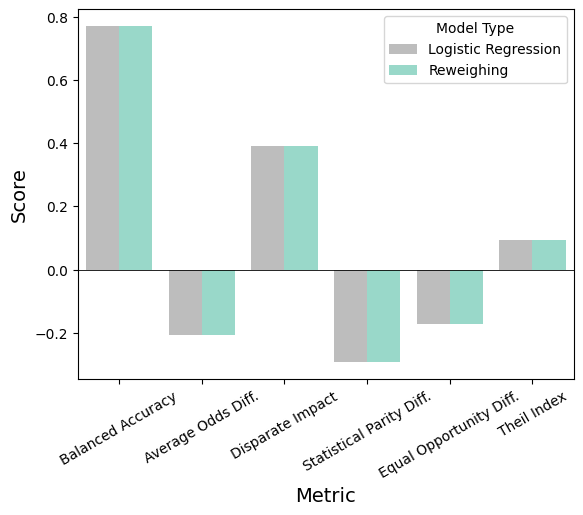

In [111]:
# log model plots
log_model_res = plot_metrics([lr_test_metric_arrs, RW_lr_test_metric_arrs], ["Logistic Regression", "Reweighing"])

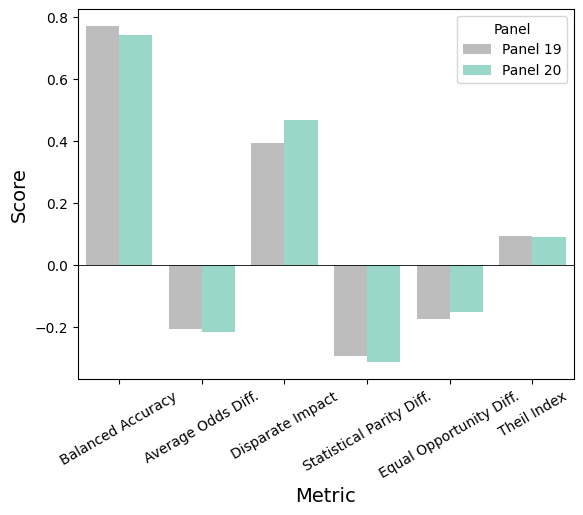

In [112]:
# log model drift plots
log_model_drift_res = plot_metrics([lr_test_metric_arrs, lr_test_metric_arrs_20], ["Panel 19", "Panel 20"], hue_title = "Panel")

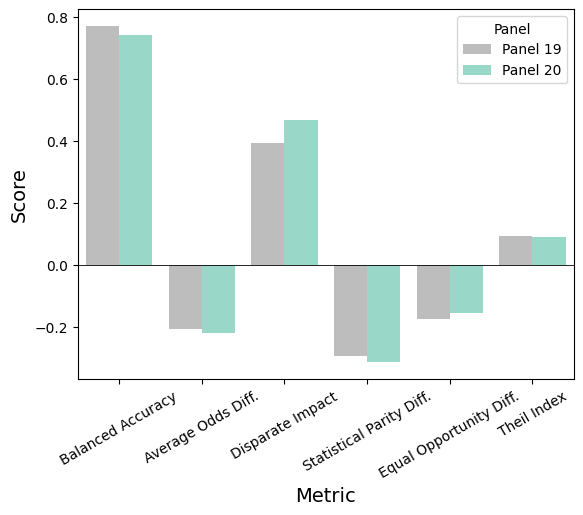

In [113]:
# reweighed log model drift_plots
rw_log_model_drift_res = plot_metrics([RW_lr_test_metric_arrs, RW_lr_test_metric_arrs_20], ["Panel 19", "Panel 20"], hue_title = "Panel")

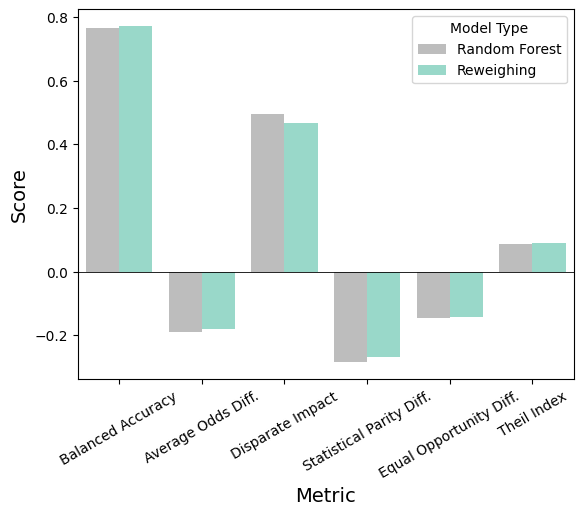

In [114]:
# random forest plots
rf_model_res = plot_metrics([rf_test_metric_arrs, RW_rf_test_metric_arrs ], ["Random Forest", "Reweighing"])

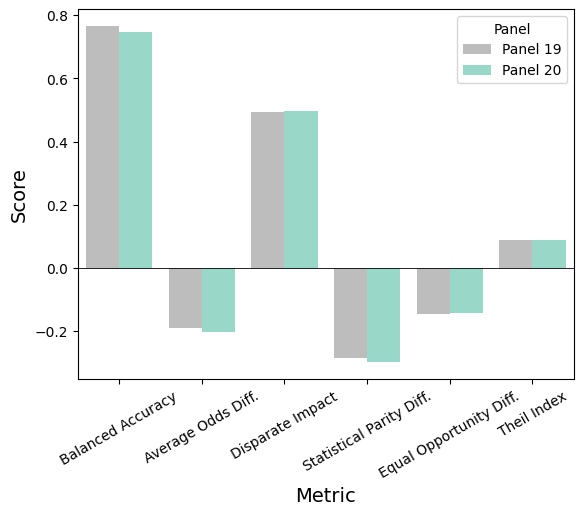

In [115]:
# random forest drift plots
rf_model_drift_res = plot_metrics([rf_test_metric_arrs, rf_test_metric_arrs_20], ["Panel 19", "Panel 20"], hue_title = "Panel")

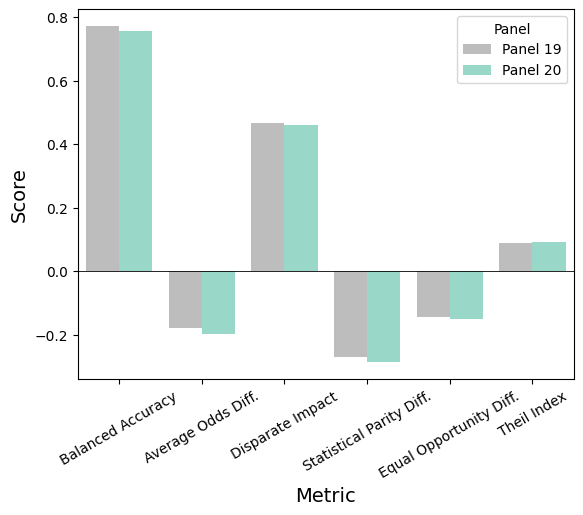

In [116]:
# reweighed random forest drift plots
rw_rf_model_drift_res = plot_metrics([RW_rf_test_metric_arrs, RW_rf_test_metric_arrs_20], ["Panel 19", "Panel 20"], hue_title = "Panel")

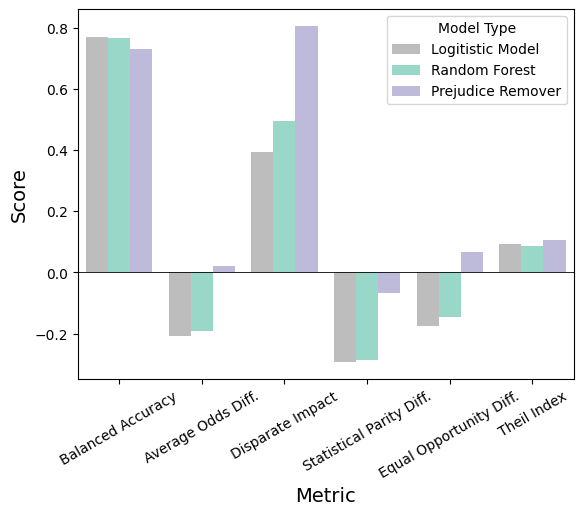

In [117]:
# prejudice remover plots
prejudice_remover_res = plot_metrics([lr_test_metric_arrs, rf_test_metric_arrs, pr_test_metric_arrs], ["Logitistic Model", "Random Forest", "Prejudice Remover"])

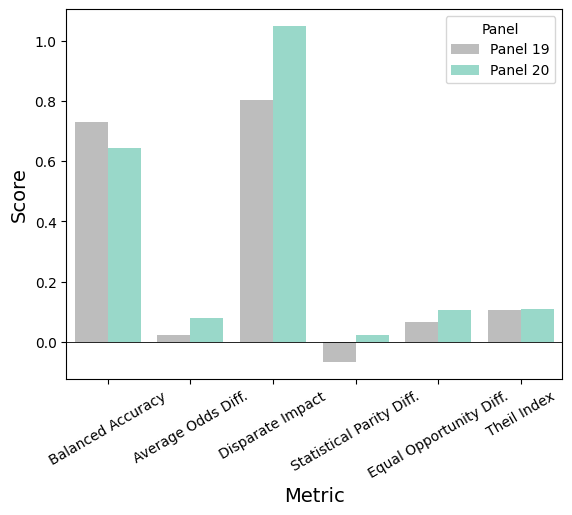

In [118]:
# prejudice remover drift plots
prejudice_remover_drift_res = plot_metrics([pr_test_metric_arrs, pr_test_metric_arrs_20], ["Panel 19", "Panel 20"], hue_title = "Panel")

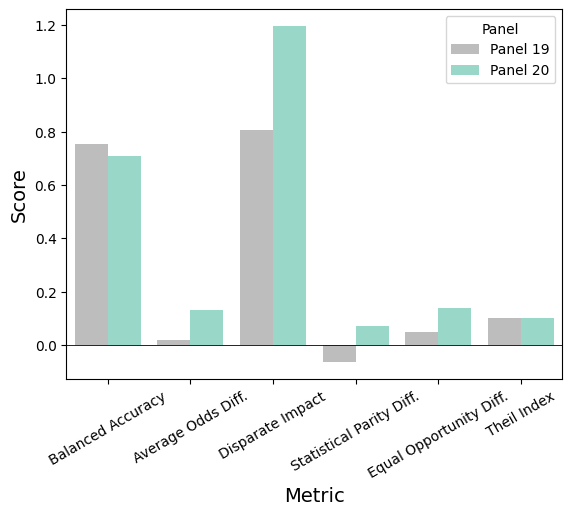

In [119]:
reject_options_classifier_lr__drift_res = plot_metrics([roc_lr_test_metric_arrs, roc_lr_test_metric_arrs_20], ["Panel 19", "Panel 20"], hue_title = "Panel")

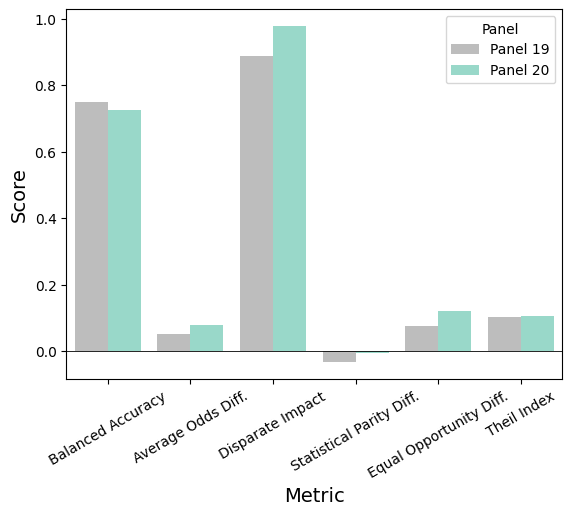

In [120]:
reject_options_classifier_rf__drift_res = plot_metrics([roc_rf_test_metric_arrs, roc_rf_test_metric_arrs_20], ["Panel 19", "Panel 20"], hue_title = "Panel")

### 5A. For **both** the logistic regression and random forest classifiers, please include visualizations the pre-processing results of your bias mitigation techniques. 

**In addition, for each Model + Bias mitigation technique, please write 1-2 SENTENCES explaining the following:**

1. Describe the bias mitigation techniques applied (what stage? type? explain what that debiasing technique does?) 

The pre-bias mitigation technique models are the baseline models that we developed, inspired by both the tutorial models and the EDA we conducted. The two model types tested are logistic regression and random forest.

2. Based on defintions and sources of bias we covered in class, what type of bias are we trying to mitigate in our models?

We are attempting to mitigate historical bias in our dataset. The protected class, "race", shows favoritism towards "White"
individuals with respect to high-utilization rates.


3. Do both models exhibit fairness and maintain accuracy? List the fairness metrics you used to support this. What about model drift?

Neither baseline model (logistic regression or random forest) exhibit fairness. Not a single fairness metric calculated was within the range of "fairness". Our log model lost accuracy when testing for model drift, also performing worse on
average odds difference and statistical parity. Its other fairness metrics remained the same or improved. The random forest model also suffered slight accuracy decreases but improved on every fairness metric except the Theil Index.

4. For the classifier ‘high’ utilization in these models + pre-processing mitigation technique; would you recommend this for our use case as a "fair" classifier? Why or why not? Use previous questions and the slide 'Sources of Bias in AI and Health Data' from our Week-07 slides, to help you answer this. 

We would not recommend these models for the use case as a fair classifier. The models show clear favoritism for based on our protected attribute of "race".

### 5B. For **both** the logistic regression and random forest classifiers, please include visualizations the post-processing results of your bias mitigation techniques. 

**In addition, for each Model + Bias mitigation technique, please write 1-2 SENTENCES explaining the following:**

1. Describe the bias mitigation techniques applied (what stage? type? explain what that debiasing technique does?) 

Both the logistic regression and random forest models were tested with two types of bias mitigation techniques. The first technique, reweighing, is a pre-processing technique that weighs examples in each (group, label) combination to attempt to combat bias. The second technique, a prejudice remover, is an in-processing strategy that adds a discrimination-aware regularization term to the learning objective.

2. Based on defintions and sources of bias we covered in class, what type of bias are we trying to mitigate in our models?

We are attempting to mitigate historical bias in our dataset. The protected class, "race", shows favoritism towards "White"
individuals with respect to high-utilization rates.

3. Do both models exhibit fairness and maintain accuracy? List the fairness metrics you used to support this. What about model drift?

Reweighing had no effect whatsoever on our logistic model. Reweighing caused slight improvements to every fairness metric for our random forest for a small accuracy cost, yet no metric was able to enter the bounds of what is considered "fair" for that metric. Therefore, we would not say that our reweighed models exhibit fairness. The prejudice remover, however, was a much more effective strategy. When compared to our logistic and random forest models, the prejudice remover is slightly less accurate but meets the threshold for every fairness metric despite a higher Theil Index, and equal opportunity difference now favoring the disadvantaged class. Model drift for the prejudice remover, continues previous trends. It sees slightly lower accuracy, and further favoritism towards the disadvantaged class on multiple fairness metrics like equal opporunity difference and disparate impact.

4. For the classifier ‘high’ utilization in these models + post-processing mitigation technique; would you recommend this for our use case as a "fair" classifier? Why or why not? Use previous questions and the slide 'Sources of Bias in AI and Health Data' from our Week-07 slides, to help you answer this. 

Of the models tested, the only model we could recommend was the prejudice remover. It was the only model that exhibited passing "fairness" values before and after model drift for multiple fairness metrics. 

### Section 5: Overall Discussion for Bias Mitigation

1. What factors must be considered during AI model-development and performance? How and where are they vulnerable to introducing bias?

The data is the most important during AI model-development. Training a model means learning the patterns and distributions in the data. The performance of a model largely depends on how representative and unbiased the data is. Therefore, exploring the data and making sure that it is representative is crucial. Combatting bias can occur in the data phase (either by feature engineering or under/oversampling) or model phase (adjusting the loss function to compensate for minority classes) 


2. How and what should be measured to assess downstream impact of AI, and what factors should be used to audit for bias and clinical impact?

Statistical metrics such as accuracy alone is not sufficient to measure downstream impact of AI. There needs to be additional metrics that reflects the success of AI such as number of users, total money saved, or even feedbacks from the users. In order to audit for bias and clinical impact, the model should be evaluated on minority groups that are susceptible to bias.

3. Define what disparate impact is. How can the type, dimension, collection-method, and representation in data lead to bias and disparate impact in communities of concern? Use the MEPS codebooks, and websites to help you explain this. Refer to Center of Disease Control (CDC) Health Equity Guiding Principles for Inclusive Communication for style recommendations when referring to affected groups.

Disparate impact is occurs when rules that appears to be neutral results in disproportionate impact on a protected group. Type and dimension of data such as converting diverse races into binary "white (1)" and "non-white (0)" can put more weight on majority "white" group while putting less weight on specific minority races since they are now all grouped as a single label. Data collection-method can easily lead to bias since one method of data collection can lead to a specific type of population while a different method leads to another population. For example collecting video recordings across the world can be bias since it targets people that are able to afford a laptop with a webcam. 

4. Where there any social factors overlooked when developing AI-targets or outcomes for the AIF360 example? How could they delay access and quality of care to underserved populations?

When developing AI-targets/outcomes for the AIF360 example, social factors overlooked could be related to median income of the area where treatment facilities are located as well as the avalible funding/resources of these facilities. When focusing on utilization, often the quality of care and delay in access are indicative of the facility rather than the patient. As a result, when developing a solution to increase outcomes for treatment groups, the analysis may need to also benchmark general performance of treatment facilities and whether their location/resources correlate with these groups.

5. (a) Overall, if you were to select ONE (a) Model, and (b) Bias-mitigation technique - for this use case where you are recommending a 'Fair' classifier for flagging 'High' utilization, which would you chose and why? (b) How would it affect Non-White beneficiaries who could have risk factor predictors that could inform a model to prioritize additional care? How could it do the opposite? (c) Explain how you would justify fair-accuracy trade-off.

If I were to select a model and bias-mitigation technique for this use case I would most likely select a Logistic Regression model that utlizes reweighting. This is because through the testing of different models/techniques, this combo is shown to be the best at achieving improved fairness in relevant metrics. Through this tehnique, it could positively affect non-White beneficiaries who may have high risk factor predictors as it attempts to equalize success and failure within groups. As a result non-White individuals who may not recieve the utliziation or proper care may have this bias mitigated through weighting. The opposite however may also occur in the case that reweighting dismisses merit and the risk-factor predictors are weighted so that they may not prioritize additional care that is needed. As a result this fairness-accuracy tradeoff could be justified in that it does serve to increase utilization between groups which is our ultimate goal, but it does sacrifice prediciting when individuals need additional care. The hope is through greater utlization, patients who need more care will recieve it through a more fair treatment process rather than needing a model to predict the need for additional care.
